<div style="background:#f5f8ff;padding:16px;border-radius:8px;border:1px solid #d6e6ff;font-family:Arial, sans-serif;line-height:1.6;color:#1a1a33">
  <h1 style="margin:0;padding:0;color:#0b3b84">Semi-Supervised Learning Pipeline for Weld Quality Classification</h1>

  <p style="margin-top:8px">
    This notebook implements an end-to-end <strong>semi-supervised learning pipeline</strong> for weld-quality classification using
    <strong>partially labeled datasets</strong>. It supports rapid experimentation and reproducible reporting by loading preprocessed
    feature splits (PCA-reduced or clean), discretizing continuous targets into quality classes, training semi-supervised labelers,
    fitting supervised classifiers on propagated labels, and exporting comprehensive results for downstream analysis.
  </p>

  <p><strong>Pipeline overview:</strong></p>
  <ul>
    <li>Load <code style="background:#eef6ff;padding:2px 4px;border-radius:3px;color:#003366">X_train/_val/_test</code> and <code>y_train/_val/_test</code> splits (clean or PCA).</li>
    <li>Discretize continuous targets into 3 quality classes (<em>Bad / Medium / Good</em>) using tertiles from labeled training data only.</li>
    <li>Train <strong>LabelPropagation</strong>, <strong>LabelSpreading</strong>, and <strong>SelfTraining</strong> models with optional hyperparameter tuning.</li>
    <li>Fit <strong>RandomForest</strong> classifiers on propagated labels and evaluate performance (F1, accuracy, confusion matrix).</li>
    <li>Export results, feature importances, and plots to <code>results/ssl_results/&lt;target&gt;/(pca|all_features)/</code>.</li>
  </ul>

  <p style="margin-top:4px">
    <strong>Inputs:</strong> cleaned or PCA feature CSVs and corresponding target files in
    <code style="background:#eef6ff;padding:2px 4px;border-radius:3px;color:#003366">data/data_splits/&lt;target&gt;/</code>.
  </p>
  <p>
    <strong>Outputs:</strong> propagated predictions, model comparison tables, confusion matrices, tuning summaries, and saved figures.
  </p>

  <p style="margin-top:4px">
    <em>Configuration:</em> set
    <code style="background:#eef6ff;padding:2px 4px;border-radius:3px;color:#003366">TARGET_NAME</code>,
    <code style="background:#eef6ff;padding:2px 4px;border-radius:3px;color:#003366">DATA_VERSION</code>
    (<code>pca</code> or <code>clean</code>), and
    <code style="background:#eef6ff;padding:2px 4px;border-radius:3px;color:#003366">ENABLE_TUNING</code> at the top of the notebook, then run cells sequentially.
  </p>

  <p style="margin-top:4px">
    <strong>Tips:</strong> compute tertiles only from labeled data to prevent leakage; disable tuning for quick runs; check warnings from SSL estimators, the notebook includes stable fallbacks and clean logging.
  </p>

  <p style="margin-top:4px">
    <em>Recommended experiments:</em> compare <strong>PCA vs. full features</strong>, evaluate <strong>different SSL strategies</strong> (LP / LS / SelfTraining),
    and test <strong>pseudo-labeling thresholds</strong> for robustness.
  </p>
</div>


In [1]:
# Imports 

import sys
sys.path.append('..')

# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path

# Semi-supervised learning
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

# Supervised learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.linear_model import LogisticRegression

# SSL functions for tuning 
from semi_supervised.ssl_training import tune_ssl_model
from semi_supervised.ssl_training import convert_to_quality_classes_tertiles


# Metrics and evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom loader
from semi_supervised.loader import load_data, TARGET_COLS

# Utilities
import warnings

print("===> All libraries imported successfully")

===> All libraries imported successfully


## 1. Configuration & Data Loading

In [2]:
# Configuration

# Target variable to predict (choose one)
TARGET_NAME = "charpy_toughness_J"
# Options: yield_strength_MPa, uts_MPa, elongation_pct, 
#          reduction_area_pct, charpy_temp_C, charpy_toughness_J

# Feature set version
DATA_VERSION = "pca"  # Options: "pca" (PCA-reduced) or "clean" (all features)

# Hyperparameter tuning
ENABLE_TUNING = True  # Set to False to use default parameters (faster execution)

print(f"Configuration:")
print(f"  Target: {TARGET_NAME}")
print(f"  Features: {DATA_VERSION}")
print(f"  Tuning: {'Enabled' if ENABLE_TUNING else 'Disabled'}")

Configuration:
  Target: charpy_toughness_J
  Features: pca
  Tuning: Enabled


In [3]:
# Load data

# project root
project_root = Path.cwd().parent.parent if 'semi_supervised' in str(Path.cwd()) else Path.cwd()
base_path = project_root / "data" / "data_splits"

# Load train, validation, and test sets
train, val, test = load_data(TARGET_NAME, data_version=DATA_VERSION, base_path=str(base_path))

if train is None:
    raise ValueError("XXX Failed to load data. Check if files exist.")

# Unpack data
X_train, y_train = train
X_val, y_val = val
X_test, y_test = test

# Display data info
print(f"\n{'='*70}")
print(f"DATA LOADED: {TARGET_NAME} ({DATA_VERSION} features)")
print(f"{'='*70}")
print(f"Training set:   {X_train.shape[0]:4d} samples x {X_train.shape[1]:3d} features")
print(f"Validation set: {X_val.shape[0]:4d} samples x {X_val.shape[1]:3d} features")
print(f"Test set:       {X_test.shape[0]:4d} samples x {X_test.shape[1]:3d} features")
print(f"{'='*70}")

Loading PCA data for target: charpy_toughness_J
Data directory: c:\Users\Ouissal\weld-quality\data\data_splits\charpy_toughness_J
==> Data loaded successfully:
  Train: X=(1300, 20), y=(1300,)
  Val:   X=(176, 20), y=(176,)
  Test:  X=(176, 20), y=(176,)
  Features: 20
--> No missing values detected

DATA LOADED: charpy_toughness_J (pca features)
Training set:   1300 samples x  20 features
Validation set:  176 samples x  20 features
Test set:        176 samples x  20 features


## 2. Quality Classification (Continuous → Classes)

In [6]:
# Convert continuous values to quality classes

# Apply classification
print(f"\n{'='*70}")
print("CONVERTING TO QUALITY CLASSES")
print(f"{'='*70}")
print("Strategy: Data-driven tertiles (33.3% / 66.6% percentiles)\n")

y_train_classes, y_val_classes, y_test_classes, threshold_low, threshold_high = \
    convert_to_quality_classes_tertiles(y_train, y_val, y_test)

print(f"===> Classification complete ! ")


CONVERTING TO QUALITY CLASSES
Strategy: Data-driven tertiles (33.3% / 66.6% percentiles)

Tertile Thresholds (from 527 labeled samples):
  Bad/Medium:   68.67
  Medium/Good:  100.00
===> Classification complete ! 



CLASS DISTRIBUTION IN TRAINING DATA
  Bad (0):       176 samples (33.4%)
  Medium (1):     38 samples (7.2%)
  Good (2):      313 samples (59.4%)
  Unlabeled:     773 samples

===> Figure saved at: c:\Users\Ouissal\weld-quality\figs\classes\classes_charpy_toughness_J.png


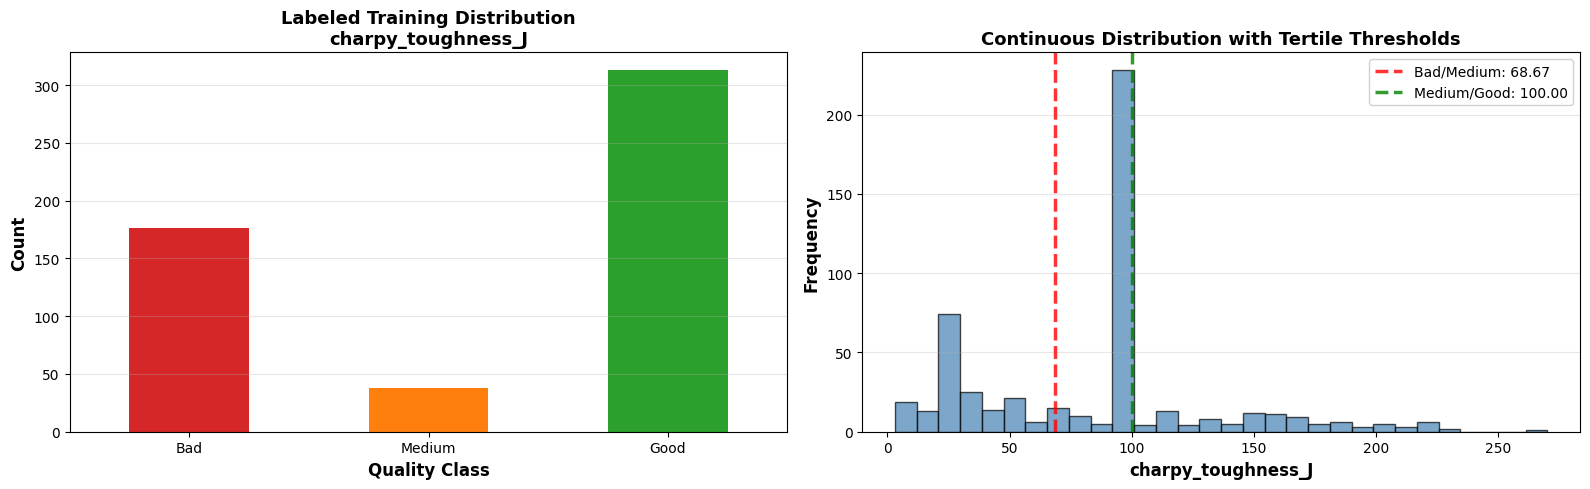

In [7]:
# Class distribution

# Calculate class distribution
labeled_mask = y_train_classes != -1
class_counts = y_train_classes[labeled_mask].value_counts().sort_index()

print(f"\n{'='*70}")
print("CLASS DISTRIBUTION IN TRAINING DATA")
print(f"{'='*70}")
print(f"  Bad (0):      {class_counts.get(0, 0):4d} samples ({class_counts.get(0, 0)/labeled_mask.sum()*100:.1f}%)")
print(f"  Medium (1):   {class_counts.get(1, 0):4d} samples ({class_counts.get(1, 0)/labeled_mask.sum()*100:.1f}%)")
print(f"  Good (2):     {class_counts.get(2, 0):4d} samples ({class_counts.get(2, 0)/labeled_mask.sum()*100:.1f}%)")
print(f"  Unlabeled:    {(y_train_classes == -1).sum():4d} samples")
print(f"{'='*70}\n")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Bar chart of class distribution
class_counts.plot(kind='bar', ax=axes[0], color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0].set_xlabel("Quality Class", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Count", fontsize=12, fontweight='bold')
axes[0].set_title(f"Labeled Training Distribution\n{TARGET_NAME}", fontsize=13, fontweight='bold')
axes[0].set_xticklabels(['Bad', 'Medium', 'Good'], rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

# Right: Histogram with tertile thresholds
labeled_y_train = y_train.dropna()
axes[1].hist(labeled_y_train, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(threshold_low, color='red', linestyle='--', linewidth=2.5, 
                label=f'Bad/Medium: {threshold_low:.2f}', alpha=0.8)
axes[1].axvline(threshold_high, color='green', linestyle='--', linewidth=2.5, 
                label=f'Medium/Good: {threshold_high:.2f}', alpha=0.8)
axes[1].set_xlabel(f"{TARGET_NAME}", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Frequency", fontsize=12, fontweight='bold')
axes[1].set_title(f"Continuous Distribution with Tertile Thresholds", fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10, framealpha=0.9)
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()

figs_dir = Path(project_root) / "figs" / "classes"
figs_dir.mkdir(parents=True, exist_ok=True)
save_path = figs_dir / f"classes_{TARGET_NAME}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"===> Figure saved at: {save_path}")

plt.show()

## 3. Hyperparameter Tuning Configuration

In [8]:
# Semi-supervised SSL parameter grids
ssl_param_grids = {
    "LabelPropagation": {
        'kernel': ['rbf', 'knn'],
        'gamma': [5, 10, 20, 30, 50],       # For RBF kernel
        'n_neighbors': [3, 5, 7, 10],       # For KNN kernel
        'max_iter': [2000]                  # Increased for better convergence
    },
    "LabelSpreading": {
        'kernel': ['rbf', 'knn'],
        'gamma': [5, 10, 20, 30, 50],       # For RBF kernel
        'alpha': [0.1, 0.2, 0.3, 0.5],      # Clamping factor
        'n_neighbors': [3, 5, 7, 10],       # For KNN kernel
        'max_iter': [2000]                  # Increased for better convergence
    },
    "SelfTraining": {
        'base_estimator': ['RandomForest', 'LogisticRegression'],  # To be mapped later to actual estimators
        'threshold': [0.6, 0.7, 0.8, 0.9],  # Confidence threshold for pseudo-labeling
        'max_iter': [10, 20, 50],           # Iterations of self-training
        'verbose': [False]                  # Optional verbosity control
    }
}

# Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Display tuning configuration
print(f"{'='*70}")
print("HYPERPARAMETER TUNING CONFIGURATION")
print(f"{'='*70}")
print(f"Status: {'ENABLED' if ENABLE_TUNING else 'DISABLED'}\n")

if ENABLE_TUNING:
    print("SSL Parameter Grids:")
    for method, params in ssl_param_grids.items():
        # Compute approximate number of combinations
        n_combos = 1
        for k, v in params.items():
            if isinstance(v, list):
                n_combos *= len(v)
        print(f"  - {method}: ~{n_combos} combinations")
    
    rf_combos = (len(rf_param_grid['n_estimators']) *
                 len(rf_param_grid['max_depth']) *
                 len(rf_param_grid['min_samples_split']) *
                 len(rf_param_grid['min_samples_leaf']) *
                 len(rf_param_grid['max_features']))
    print(f"  - Random Forest: 30 random samples from ~{rf_combos} combinations")
else:
    print("Using default parameters (fast mode)")

print(f"{'='*70}")


HYPERPARAMETER TUNING CONFIGURATION
Status: ENABLED

SSL Parameter Grids:
  - LabelPropagation: ~40 combinations
  - LabelSpreading: ~160 combinations
  - SelfTraining: ~24 combinations
  - Random Forest: 30 random samples from ~216 combinations


## 4. Semi-Supervised Learning Training

In [9]:
# =========================
# 4) SSL HYPERPARAMETER TUNING
# =========================

import warnings
# Supprime le FutureWarning scikit-learn lié à base_estimator (pendant le tuning)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module=r"sklearn\.semi_supervised\._self_training"
)

if ENABLE_TUNING:
    print(f"\n{'='*70}")
    print("SSL HYPERPARAMETER TUNING")
    print(f"{'='*70}")
    print("Note: Convergence warnings are suppressed for cleaner output\n")

    tuning_results = {}
    best_ssl_models = {}
    best_ssl_params = {}

    # Tune LabelPropagation
    best_lp_model, best_lp_params, best_lp_score, lp_results = tune_ssl_model(
        LabelPropagation, ssl_param_grids['LabelPropagation'],
        X_train.values, y_train_classes.values, X_val.values, y_val_classes,
        "LabelPropagation"
    )
    best_ssl_models['LabelPropagation'] = best_lp_model
    best_ssl_params['LabelPropagation'] = best_lp_params
    tuning_results['LabelPropagation'] = lp_results

    # Tune LabelSpreading
    best_ls_model, best_ls_params, best_ls_score, ls_results = tune_ssl_model(
        LabelSpreading, ssl_param_grids['LabelSpreading'],
        X_train.values, y_train_classes.values, X_val.values, y_val_classes,
        "LabelSpreading"
    )
    best_ssl_models['LabelSpreading'] = best_ls_model
    best_ssl_params['LabelSpreading'] = best_ls_params
    tuning_results['LabelSpreading'] = ls_results

    # Tune SelfTraining
    # (Le warning vient de l'usage de base_estimator dans tune_ssl_model.
    #  Pour le supprimer définitivement, modifie tune_ssl_model pour utiliser `estimator=`.)
    best_st_model, best_st_params, best_st_score, st_results = tune_ssl_model(
        SelfTrainingClassifier, ssl_param_grids['SelfTraining'],
        X_train.values, y_train_classes.values, X_val.values, y_val_classes,
        "SelfTraining"
    )
    best_ssl_models['SelfTraining'] = best_st_model
    best_ssl_params['SelfTraining'] = best_st_params
    tuning_results['SelfTraining'] = st_results

    print(f"\n{'='*70}")
    print("===> SSL TUNING COMPLETED")
    print(f"{'='*70}")

    ssl_models = best_ssl_models

else:
    # Use default parameters (fast mode)
    ssl_models = {
        "LabelPropagation": LabelPropagation(kernel='rbf', gamma=20, max_iter=1000, tol=1e-3),
        "LabelSpreading":  LabelSpreading(kernel='rbf', gamma=20, alpha=0.2, max_iter=1000, tol=1e-3),
        # ✅ Correction: utiliser `estimator=` (et plus `base_estimator=`) pour SelfTrainingClassifier
        "SelfTraining":    SelfTrainingClassifier(
            estimator=LogisticRegression(max_iter=1000),
            threshold=0.8,
            max_iter=20,
            verbose=False
        ),
    }

    print(f"\n{'='*70}")
    print("USING DEFAULT SSL PARAMETERS")
    print(f"{'='*70}")
    print("LabelPropagation: kernel='rbf', gamma=20")
    print("LabelSpreading:   kernel='rbf', gamma=20, alpha=0.2")
    print("SelfTraining:     estimator=LogisticRegression(max_iter=1000), threshold=0.8, max_iter=20")
    print(f"{'='*70}")


SSL HYPERPARAMETER TUNING
Note: Convergence warnings are suppressed for cleaner output


TUNING LabelPropagation

===> Tested 9 parameter combinations

Top 3 configurations:
kernel  gamma  max_iter  val_f1_score  n_neighbors
   knn    NaN      2000      0.623346          7.0
   knn    NaN      2000      0.598620          5.0
   knn    NaN      2000      0.596921         10.0

──────────────────────────────────────────────────────────────────────
BEST: {'kernel': 'knn', 'n_neighbors': 7, 'max_iter': 2000}
Validation F1 Score (weighted): 62.33%
──────────────────────────────────────────────────────────────────────

TUNING LabelSpreading

===> Tested 36 parameter combinations

Top 3 configurations:
kernel  gamma  max_iter  alpha  val_f1_score  n_neighbors
   knn    NaN      2000    0.1      0.613783         10.0
   knn    NaN      2000    0.3      0.613783          7.0
   knn    NaN      2000    0.1      0.611522          7.0

─────────────────────────────────────────────────────────────

In [10]:
# ==========================================
# 4)5bis) TRAIN SSL MODELS AND PROPAGATE LABELS (robuste)
# ==========================================

import numpy as np
import warnings
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier

print(f"\n{'='*70}")
print("TRAINING SEMI-SUPERVISED MODELS")
print(f"{'='*70}\n")

predictions = {}
trained_models = {}

def _has_nan_distributions(model):
    # pour LP/LS uniquement
    return hasattr(model, "label_distributions_") and np.isnan(model.label_distributions_).any()

for method_name, model in ssl_models.items():
    if model is None:
        print(f"[{method_name}]")
        print("  Skipped (no model selected during tuning).\n")
        continue

    print(f"[{method_name}]")
    n_total = len(y_train_classes)
    n_labeled = int((y_train_classes != -1).sum())
    n_unlabeled = n_total - n_labeled
    print(f"  Training on {n_total} samples...")
    print(f"    - Labeled:   {n_labeled:4d}")
    print(f"    - Unlabeled: {n_unlabeled:4d}")

    # y en int, comme attendu par sklearn (avec -1 pour unlabeled)
    y_train_arr = pd.Series(y_train_classes).astype(int).values

    # Fit (on supprime l’affichage des warnings de convergence pendant l’entraînement)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train.values, y_train_arr)

    # Si LabelPropagation a produit des NaN, on bascule vers LabelSpreading
    if isinstance(model, LabelPropagation) and _has_nan_distributions(model):
        print("  [!] LabelPropagation produced NaNs; switching to LabelSpreading with similar params.")
        # récupérer params communs
        params = model.get_params()
        params.pop("tol", None)  # LS accepte tol mais on garde safe
        # certains params peuvent ne pas exister selon ta version; on nettoie prudemment
        safe_params = {k: v for k, v in params.items()
                       if k in LabelSpreading().get_params().keys()}
        fallback = LabelSpreading(**safe_params)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fallback.fit(X_train.values, y_train_arr)
        model = fallback  # on remplace

    # ------- Propagation sécurisée (pas de -1 dans le train propagé) -------
    if hasattr(model, "transduction_"):   # LP / LS
        y_train_propagated = model.transduction_.astype(int)
    elif isinstance(model, SelfTrainingClassifier) or method_name.lower().startswith("selftraining"):
        y_pred_all = model.predict(X_train.values).astype(int)
        y_train_propagated = np.where(
            y_train_arr != -1,
            y_train_arr,
            y_pred_all
        )
    else:
        y_train_propagated = y_train_arr

    # Dernière sécu: remplace toute trace résiduelle de -1 par la prédiction brute
    if (y_train_propagated == -1).any():
        y_pred_all = model.predict(X_train.values).astype(int)
        y_train_propagated = np.where(y_train_propagated == -1, y_pred_all, y_train_propagated)

    # ------- Prédictions val/test (cast en int) -------
    y_val_pred  = model.predict(X_val.values).astype(int)
    y_test_pred = model.predict(X_test.values).astype(int)

    # ------- Stockage -------
    predictions[method_name] = {
        'train': y_train_propagated,
        'val':   y_val_pred,
        'test':  y_test_pred
    }
    trained_models[method_name] = model

    # ------- Évaluation -------
    val_accuracy = accuracy_score(y_val_classes, y_val_pred)
    val_f1 = f1_score(y_val_classes, y_val_pred, average='weighted', labels=[0,1,2])
    print(f"  ===> Training completed")
    print(f"  ===> Validation Accuracy: {val_accuracy*100:.2f}%")
    print(f"  ===> Validation F1 Score: {val_f1*100:.2f}%\n")

print(f"{'='*70}")
print("===> ALL SSL MODELS TRAINED !")
print(f"{'='*70}")


TRAINING SEMI-SUPERVISED MODELS

[LabelPropagation]
  Training on 1300 samples...
    - Labeled:    527
    - Unlabeled:  773
  ===> Training completed
  ===> Validation Accuracy: 64.20%
  ===> Validation F1 Score: 62.33%

[LabelSpreading]
  Training on 1300 samples...
    - Labeled:    527
    - Unlabeled:  773
  ===> Training completed
  ===> Validation Accuracy: 64.77%
  ===> Validation F1 Score: 61.38%

[SelfTraining]
  Training on 1300 samples...
    - Labeled:    527
    - Unlabeled:  773
  ===> Training completed
  ===> Validation Accuracy: 64.77%
  ===> Validation F1 Score: 61.37%

===> ALL SSL MODELS TRAINED !


## 5. Random Forest Training on Propagated Labels

In [11]:
# =====================================================
# 5) TRAINING RANDOM FOREST CLASSIFIERS (DEFAULT PARAMS)
# =====================================================

print(f"\n{'='*70}")
print("TRAINING RANDOM FOREST CLASSIFIERS")
print(f"{'='*70}\n")

rf_models = {}
rf_predictions = {}

for ssl_method in ssl_models.keys():
    print(f"[RF + {ssl_method}]")

    # 1) Récupérer labels propagés et PURGER les -1
    y_train_ssl = pd.Series(predictions[ssl_method]['train']).astype(int)
    mask = (y_train_ssl != -1)
    X_train_rf = X_train.values[mask]
    y_train_rf = y_train_ssl[mask].values

    # 2) Entraîner le RF uniquement sur {0,1,2}
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    print(f"  Training on {len(y_train_rf)} samples (propagated labels, no -1)...")
    rf.fit(X_train_rf, y_train_rf)
    print("  RF classes_ ->", rf.classes_)  # doit afficher [0 1 2]

    # 3) Prédire
    y_val_pred_rf  = rf.predict(X_val.values).astype(int)
    y_test_pred_rf = rf.predict(X_test.values).astype(int)

    # 4) Stocker
    rf_models[ssl_method] = rf
    rf_predictions[ssl_method] = {'val': y_val_pred_rf, 'test': y_test_pred_rf}

    # 5) Évaluer
    val_accuracy_rf = accuracy_score(y_val_classes, y_val_pred_rf)
    val_f1_rf = f1_score(y_val_classes, y_val_pred_rf, average='weighted')
    print(f"  ===> Training completed")
    print(f"  ===> Validation Accuracy: {val_accuracy_rf*100:.2f}%")
    print(f"  ===> Validation F1 Score: {val_f1_rf*100:.2f}%\n")

print(f"{'='*70}")
print("===> ALL RANDOM FOREST MODELS TRAINED")
print(f"{'='*70}")


TRAINING RANDOM FOREST CLASSIFIERS

[RF + LabelPropagation]
  Training on 1300 samples (propagated labels, no -1)...
  RF classes_ -> [0 1 2]
  ===> Training completed
  ===> Validation Accuracy: 62.50%
  ===> Validation F1 Score: 59.72%

[RF + LabelSpreading]
  Training on 1300 samples (propagated labels, no -1)...
  RF classes_ -> [0 1 2]
  ===> Training completed
  ===> Validation Accuracy: 62.50%
  ===> Validation F1 Score: 58.95%

[RF + SelfTraining]
  Training on 1300 samples (propagated labels, no -1)...
  RF classes_ -> [0 1 2]
  ===> Training completed
  ===> Validation Accuracy: 64.20%
  ===> Validation F1 Score: 60.89%

===> ALL RANDOM FOREST MODELS TRAINED


In [12]:
# =========================================
# 5bis) RF HYPERPARAMETER TUNING
# =========================================

from semi_supervised.ssl_training import tune_random_forest

if ENABLE_TUNING:
    print(f"\n{'='*70}")
    print("RF HYPERPARAMETER TUNING")
    print(f"{'='*70}")

    best_rf_models = {}
    best_rf_params = {}
    rf_tuning_results = {}

    for ssl_method in ssl_models.keys():
        # 1) Labels propagés et PURGE -1 avant le CV
        y_train_ssl = pd.Series(predictions[ssl_method]['train']).astype(int)
        mask = (y_train_ssl != -1)
        X_train_rf = X_train.values[mask]
        y_train_rf = y_train_ssl[mask].values

        # 2) Tuning sur données filtrées
        best_rf, best_params, val_score, rf_results = tune_random_forest(
            X_train_rf, y_train_rf, X_val.values, y_val_classes,
            rf_param_grid, ssl_method, n_iter=30
        )

        best_rf_models[ssl_method] = best_rf
        best_rf_params[ssl_method] = best_params
        rf_tuning_results[ssl_method] = rf_results

    print(f"\n{'='*70}")
    print("===> RF TUNING COMPLETED")
    print(f"{'='*70}")

    # 3) Utiliser les meilleurs RF et re-prédire
    rf_models = best_rf_models
    rf_predictions = {}
    for ssl_method, rf_model in rf_models.items():
        # Sanity check
        print(f"[RF + {ssl_method}] best classes_ ->", rf_model.classes_)  # doit être [0 1 2]
        rf_predictions[ssl_method] = {
            'val':  rf_model.predict(X_val.values).astype(int),
            'test': rf_model.predict(X_test.values).astype(int)
        }
else:
    print(f"\n{'='*70}")
    print("SKIPPING RF TUNING")
    print(f"{'='*70}")
    print("Using default parameters from previous cell")
    print(f"{'='*70}")


RF HYPERPARAMETER TUNING

TUNING RF (trained on LabelPropagation labels)
Running RandomizedSearchCV (30 iterations, 3-fold CV)...
Scoring: F1 Score (weighted)

===> Tuning completed !

Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
Best CV F1 score: 83.25%
Validation Accuracy: 62.50%
Validation F1 Score: 59.72%

TUNING RF (trained on LabelSpreading labels)
Running RandomizedSearchCV (30 iterations, 3-fold CV)...
Scoring: F1 Score (weighted)

===> Tuning completed !

Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 15}
Best CV F1 score: 83.00%
Validation Accuracy: 62.50%
Validation F1 Score: 59.22%

TUNING RF (trained on SelfTraining labels)
Running RandomizedSearchCV (30 iterations, 3-fold CV)...
Scoring: F1 Score (weighted)

===> Tuning completed !

Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1

## 6. Model Evaluation & Comparison

In [13]:
# ==================================================
# 6) MODEL EVALUATION & COMPARISON — SUMMARY TABLE
# ==================================================

print(f"\n{'='*70}")
print("MODEL EVALUATION SUMMARY")
print(f"{'='*70}\n")

def _safe_scores(y_true, y_pred):
    """Calcule Accuracy/F1 sur les classes {0,1,2}."""
    y_true = pd.Series(y_true).astype(int).values
    y_pred = pd.Series(y_pred).astype(int).values
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='weighted', labels=[0,1,2])
    return acc, f1

results = []

# Evaluate SSL models
for method_name in ssl_models.keys():
    val_acc,  val_f1  = _safe_scores(y_val_classes,  predictions[method_name]['val'])
    test_acc, test_f1 = _safe_scores(y_test_classes, predictions[method_name]['test'])

    results.append({
        'Model': method_name,
        'Val Accuracy': f"{val_acc*100:.2f}%",
        'Val F1': f"{val_f1*100:.2f}%",
        'Test Accuracy': f"{test_acc*100:.2f}%",
        'Test F1': f"{test_f1*100:.2f}%"
    })

# Evaluate RF models
for method_name in rf_models.keys():
    val_acc,  val_f1  = _safe_scores(y_val_classes,  rf_predictions[method_name]['val'])
    test_acc, test_f1 = _safe_scores(y_test_classes, rf_predictions[method_name]['test'])

    results.append({
        'Model': f"RF + {method_name}",
        'Val Accuracy': f"{val_acc*100:.2f}%",
        'Val F1': f"{val_f1*100:.2f}%",
        'Test Accuracy': f"{test_acc*100:.2f}%",
        'Test F1': f"{test_f1*100:.2f}%"
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print(f"\n{'='*70}")


MODEL EVALUATION SUMMARY

                Model Val Accuracy Val F1 Test Accuracy Test F1
     LabelPropagation       64.20% 62.33%        63.64%  63.32%
       LabelSpreading       64.77% 61.38%        64.20%  63.25%
         SelfTraining       64.77% 61.37%        71.59%  69.74%
RF + LabelPropagation       62.50% 59.72%        65.34%  64.74%
  RF + LabelSpreading       62.50% 59.22%        62.50%  61.22%
    RF + SelfTraining       64.77% 61.09%        69.32%  67.63%



In [14]:
from pathlib import Path

def _figs_dir_by_version(project_root, DATA_VERSION):
    sub = "pca" if DATA_VERSION == "pca" else "all_features"
    d = Path(project_root) / "figs" / sub
    d.mkdir(parents=True, exist_ok=True)
    return d

def _ssl_abbr(method):
    m = method.lower()
    if "labelspreading" in m:   return "ls"
    if "labelpropagation" in m: return "lp"
    if "selftraining" in m:     return "self_training"
    return m.replace(" ", "_")

def _short_target(t):
    mapping = {
        "yield_strength_MPa": "yield",
        "uts_MPa": "uts",
        "elongation_pct": "elongation",
        "reduction_area_pct": "reduction",
        "charpy_temp_C": "charpy_temp",
        "charpy_toughness_J": "charpy_toughness",
    }
    return mapping.get(t, t)


DETAILED EVALUATION: BEST MODELS (by F1 Score)
Best SSL: LabelPropagation
Best RF:  RF + SelfTraining

──────────────────────────────────────────────────────────────────────
BEST SSL MODEL: LabelPropagation
──────────────────────────────────────────────────────────────────────

Test Accuracy: 63.64%
Test F1 Score: 63.32%

Classification Report:
              precision    recall  f1-score   support

         Bad       0.41      0.46      0.43        50
      Medium       1.00      0.14      0.25         7
        Good       0.74      0.74      0.74       119

    accuracy                           0.64       176
   macro avg       0.72      0.45      0.47       176
weighted avg       0.66      0.64      0.63       176

===> SSL confusion matrix saved at: c:\Users\Ouissal\weld-quality\figs\pca\lp_charpy_toughness.png


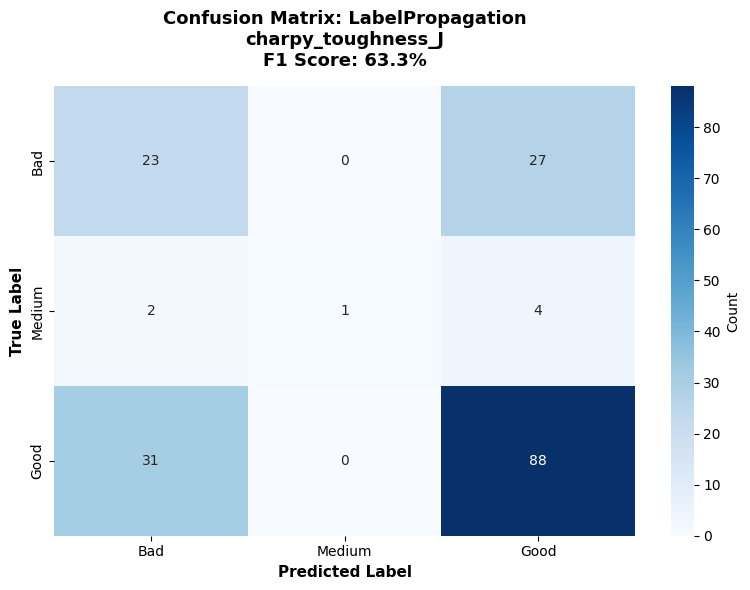


──────────────────────────────────────────────────────────────────────
BEST RF MODEL: RF + SelfTraining
──────────────────────────────────────────────────────────────────────

Test Accuracy: 69.32%
Test F1 Score: 67.63%

Classification Report:
              precision    recall  f1-score   support

         Bad       0.50      0.38      0.43        50
      Medium       0.67      0.29      0.40         7
        Good       0.75      0.85      0.80       119

    accuracy                           0.69       176
   macro avg       0.64      0.50      0.54       176
weighted avg       0.67      0.69      0.68       176

===> RF confusion matrix saved at: c:\Users\Ouissal\weld-quality\figs\pca\rf_self_training_charpy_toughness.png


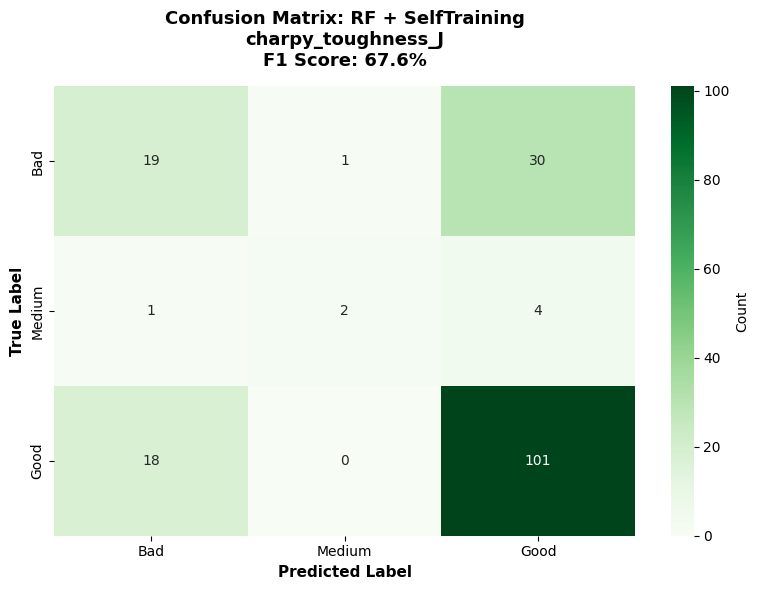


──────────────────────────────────────────────────────────────────────
TOP 10 FEATURE IMPORTANCES (RF + SelfTraining)
──────────────────────────────────────────────────────────────────────
feature  importance
    PC1    0.156676
    PC2    0.131296
    PC3    0.095248
    PC5    0.085662
    PC4    0.072488
    PC6    0.070926
   PC16    0.051724
   PC10    0.050437
    PC7    0.042655
   PC12    0.032200
===> RF feature importance saved at: c:\Users\Ouissal\weld-quality\figs\pca\rf_feature_importance_charpy_toughness.png


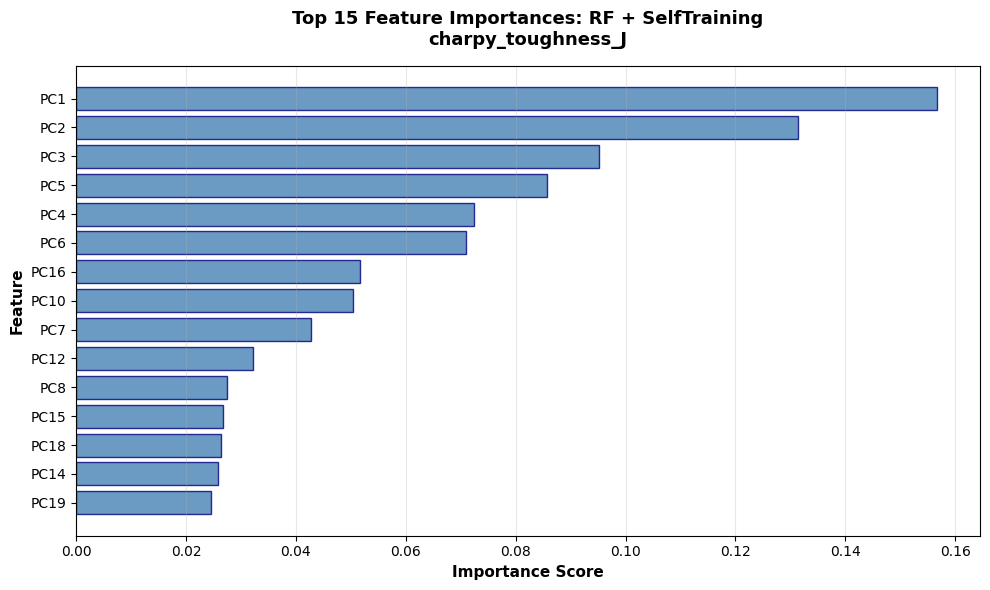

In [15]:
# ==================================================
# 6bis) DETAILED EVALUATION — BEST SSL & BEST RF
# ==================================================

from sklearn.metrics import classification_report, confusion_matrix

def _safe_f1_for_selection(y_true, y_pred):
    """F1 pondéré pour la sélection."""
    y_true = pd.Series(y_true).astype(int).values
    y_pred = pd.Series(y_pred).astype(int).values
    return f1_score(y_true, y_pred, average='weighted', labels=[0,1,2])

# Sélection des meilleurs modèles sur F1(val)
best_ssl_method = max(
    ssl_models.keys(),
    key=lambda x: _safe_f1_for_selection(y_val_classes, predictions[x]['val'])
)
best_rf_method = max(
    rf_models.keys(),
    key=lambda x: _safe_f1_for_selection(y_val_classes, rf_predictions[x]['val'])
)

print(f"\n{'='*70}")
print("DETAILED EVALUATION: BEST MODELS (by F1 Score)")
print(f"{'='*70}")
print(f"Best SSL: {best_ssl_method}")
print(f"Best RF:  RF + {best_rf_method}")
print(f"{'='*70}\n")

# -------- Best SSL --------
print(f"{'─'*70}")
print(f"BEST SSL MODEL: {best_ssl_method}")
print(f"{'─'*70}\n")

y_test_pred_best_ssl = pd.Series(predictions[best_ssl_method]['test']).astype(int).values
y_true_ssl = pd.Series(y_test_classes).astype(int).values

test_acc_ssl = accuracy_score(y_true_ssl, y_test_pred_best_ssl)
test_f1_ssl  = f1_score(y_true_ssl, y_test_pred_best_ssl, average='weighted', labels=[0,1,2])

print(f"Test Accuracy: {test_acc_ssl*100:.2f}%")
print(f"Test F1 Score: {test_f1_ssl*100:.2f}%\n")
print("Classification Report:")
print(classification_report(
    y_true_ssl, y_test_pred_best_ssl,
    labels=[0,1,2], target_names=['Bad','Medium','Good'], zero_division=0
))

cm_ssl = confusion_matrix(y_true_ssl, y_test_pred_best_ssl, labels=[0,1,2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ssl, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad','Medium','Good'],
            yticklabels=['Bad','Medium','Good'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix: {best_ssl_method}\n{TARGET_NAME}\nF1 Score: {test_f1_ssl*100:.1f}%',
          fontsize=13, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=11, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')
plt.tight_layout()

figs_dir = _figs_dir_by_version(project_root, DATA_VERSION)
ssl_tag  = _ssl_abbr(best_ssl_method)
t_short  = _short_target(TARGET_NAME)
ssl_path = figs_dir / f"{ssl_tag}_{t_short}.png"

plt.savefig(ssl_path, dpi=300, bbox_inches='tight')
print(f"===> SSL confusion matrix saved at: {ssl_path}")

plt.show()

# -------- Best RF --------
print(f"\n{'─'*70}")
print(f"BEST RF MODEL: RF + {best_rf_method}")
print(f"{'─'*70}\n")

y_test_pred_best_rf = pd.Series(rf_predictions[best_rf_method]['test']).astype(int).values
y_true_rf = pd.Series(y_test_classes).astype(int).values

test_acc_rf = accuracy_score(y_true_rf, y_test_pred_best_rf)
test_f1_rf  = f1_score(y_true_rf, y_test_pred_best_rf, average='weighted', labels=[0,1,2])

print(f"Test Accuracy: {test_acc_rf*100:.2f}%")
print(f"Test F1 Score: {test_f1_rf*100:.2f}%\n")
print("Classification Report:")
print(classification_report(
    y_true_rf, y_test_pred_best_rf,
    labels=[0,1,2], target_names=['Bad','Medium','Good'], zero_division=0
))

cm_rf = confusion_matrix(y_true_rf, y_test_pred_best_rf, labels=[0,1,2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Bad','Medium','Good'],
            yticklabels=['Bad','Medium','Good'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix: RF + {best_rf_method}\n{TARGET_NAME}\nF1 Score: {test_f1_rf*100:.1f}%',
          fontsize=13, fontweight='bold', pad=15)
plt.ylabel('True Label', fontsize=11, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=11, fontweight='bold')
plt.tight_layout()

figs_dir = _figs_dir_by_version(project_root, DATA_VERSION)
rf_tag   = f"rf_{_ssl_abbr(best_rf_method)}"
t_short  = _short_target(TARGET_NAME)
rf_path  = figs_dir / f"{rf_tag}_{t_short}.png"

plt.savefig(rf_path, dpi=300, bbox_inches='tight')
print(f"===> RF confusion matrix saved at: {rf_path}")

plt.show()

# -------- Feature importance (RF) --------
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_models[best_rf_method].feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n{'─'*70}")
print(f"TOP 10 FEATURE IMPORTANCES (RF + {best_rf_method})")
print(f"{'─'*70}")
print(feature_importance.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values,
         color='steelblue', edgecolor='navy', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'].values, fontsize=10)
plt.xlabel('Importance Score', fontsize=11, fontweight='bold')
plt.ylabel('Feature', fontsize=11, fontweight='bold')
plt.title(f'Top 15 Feature Importances: RF + {best_rf_method}\n{TARGET_NAME}',
          fontsize=13, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()

figs_dir = _figs_dir_by_version(project_root, DATA_VERSION)
fi_path  = figs_dir / f"rf_feature_importance_{_short_target(TARGET_NAME)}.png"
plt.savefig(fi_path, dpi=300, bbox_inches='tight')
print(f"===> RF feature importance saved at: {fi_path}")

plt.show()

print(f"\n{'='*70}")

In [16]:
import numpy as np, pandas as pd

print("Unique y_test_classes:", np.sort(pd.Series(y_test_classes).unique()))
print("Unique y_val_classes:",  np.sort(pd.Series(y_val_classes).unique()))
print("Unique y_pred_best_rf:", np.sort(pd.Series(y_test_pred_best_rf).unique()))
print("Nb -1 (test y_true):", int((y_test_classes == -1).sum()))
print("Nb -1 (val y_true): ", int((y_val_classes  == -1).sum()))

Unique y_test_classes: [0. 1. 2.]
Unique y_val_classes: [0. 1. 2.]
Unique y_pred_best_rf: [0 1 2]
Nb -1 (test y_true): 0
Nb -1 (val y_true):  0


## 7. Export Results & Save Models

In [17]:
# =========================================
# SAVE RESULTS TO DISK (version-aware path)
# =========================================

# Version-specific results directory (same logic as tuning block)
results_dir = (
    project_root / "results" / "ssl_results" / TARGET_NAME /
    ("pca" if DATA_VERSION == "pca" else "all_features")
)
results_dir.mkdir(parents=True, exist_ok=True)

print(f"\n{'='*70}")
print("SAVING RESULTS")
print(f"{'='*70}\n")

# Save predictions for all models
for method_name in ssl_models.keys():
    # SSL predictions
    pd.DataFrame({
        'true': y_test_classes,
        'predicted': predictions[method_name]['test']
    }).to_csv(results_dir / f"{method_name}_predictions.csv", index=False)

    # RF predictions
    pd.DataFrame({
        'true': y_test_classes,
        'predicted': rf_predictions[method_name]['test']
    }).to_csv(results_dir / f"RF_{method_name}_predictions.csv", index=False)

print("===> Predictions saved !")

# Save model comparison table
results_df.to_csv(results_dir / "model_comparison.csv", index=False)
print("===> Model comparison saved !")

# Save feature importance (if using clean features)
if DATA_VERSION == "clean":
    feature_importance.to_csv(results_dir / "feature_importance.csv", index=False)
    print("===> Feature importance saved !")

# Save quality thresholds for reproducibility
pd.DataFrame({
    'threshold_type': ['Bad/Medium (33.3%)', 'Medium/Good (66.6%)'],
    'value': [threshold_low, threshold_high]
}).to_csv(results_dir / "quality_thresholds.csv", index=False)
print("===> Quality thresholds saved !")

print(f"\n{'─'*70}")
print(f"Results directory: {results_dir}")
print(f"{'─'*70}")
print(f"\n{'='*70}")
print("===> PIPELINE COMPLETED SUCCESSFULLY !")
print(f"{'='*70}")


SAVING RESULTS

===> Predictions saved !
===> Model comparison saved !
===> Quality thresholds saved !

──────────────────────────────────────────────────────────────────────
Results directory: c:\Users\Ouissal\weld-quality\results\ssl_results\charpy_toughness_J\pca
──────────────────────────────────────────────────────────────────────

===> PIPELINE COMPLETED SUCCESSFULLY !


In [18]:
# ==========================================================
# SAVE HYPERPARAMETER TUNING RESULTS (if tuning was enabled)
# ==========================================================

if ENABLE_TUNING:
    print(f"\n{'='*70}")
    print("SAVING HYPERPARAMETER TUNING RESULTS")
    print(f"{'='*70}\n")

    # version-specific results folder
    results_dir = (
        project_root / "results" / "ssl_results" / TARGET_NAME /
        ("pca" if DATA_VERSION == "pca" else "all_features")
    )
    results_dir.mkdir(parents=True, exist_ok=True)

    # create tuning subfolder
    tuning_dir = results_dir / "tuning"
    tuning_dir.mkdir(exist_ok=True)

    # ----------------------------
    # Save SSL tuning results
    # ----------------------------
    for method_name, tuning_df in tuning_results.items():
        out_path = tuning_dir / f"{method_name}_tuning_results.csv"
        tuning_df.to_csv(out_path, index=False)
        print(f"===> {method_name} tuning results saved at: {out_path}")

    # ----------------------------
    # Save RF tuning results
    # ----------------------------
    for method_name, tuning_df in rf_tuning_results.items():
        cols = [
            col for col in tuning_df.columns
            if any(x in col for x in ['param_', 'mean_test', 'std_test', 'rank_test'])
        ]
        out_path = tuning_dir / f"RF_{method_name}_tuning_results.csv"
        tuning_df[cols].to_csv(out_path, index=False)
        print(f"===> RF + {method_name} tuning results saved at: {out_path}")

    # ----------------------------
    # Save best parameters summary
    # ----------------------------
    ssl_params_df = pd.DataFrame([
        {'Method': method, **params}
        for method, params in best_ssl_params.items()
    ])
    ssl_params_path = tuning_dir / "best_ssl_parameters.csv"
    ssl_params_df.to_csv(ssl_params_path, index=False)
    print(f"===> Best SSL parameters saved at: {ssl_params_path}")

    rf_params_df = pd.DataFrame([
        {'SSL_Method': method, **params}
        for method, params in best_rf_params.items()
    ])
    rf_params_path = tuning_dir / "best_rf_parameters.csv"
    rf_params_df.to_csv(rf_params_path, index=False)
    print(f"===> Best RF parameters saved at: {rf_params_path}")

    # ----------------------------
    # Summary
    # ----------------------------
    print(f"\n{'─'*70}")
    print(f"Tuning results directory: {tuning_dir}")
    print(f"{'─'*70}")
    print(f"\n{'='*70}")
    print("===> TUNING RESULTS SAVED SUCCESSFULLY")
    print(f"{'='*70}")

else:
    print(f"\n{'='*70}")
    print("TUNING DISABLED — No tuning results to save")
    print(f"{'='*70}")


SAVING HYPERPARAMETER TUNING RESULTS

===> LabelPropagation tuning results saved at: c:\Users\Ouissal\weld-quality\results\ssl_results\charpy_toughness_J\pca\tuning\LabelPropagation_tuning_results.csv
===> LabelSpreading tuning results saved at: c:\Users\Ouissal\weld-quality\results\ssl_results\charpy_toughness_J\pca\tuning\LabelSpreading_tuning_results.csv
===> SelfTraining tuning results saved at: c:\Users\Ouissal\weld-quality\results\ssl_results\charpy_toughness_J\pca\tuning\SelfTraining_tuning_results.csv
===> RF + LabelPropagation tuning results saved at: c:\Users\Ouissal\weld-quality\results\ssl_results\charpy_toughness_J\pca\tuning\RF_LabelPropagation_tuning_results.csv
===> RF + LabelSpreading tuning results saved at: c:\Users\Ouissal\weld-quality\results\ssl_results\charpy_toughness_J\pca\tuning\RF_LabelSpreading_tuning_results.csv
===> RF + SelfTraining tuning results saved at: c:\Users\Ouissal\weld-quality\results\ssl_results\charpy_toughness_J\pca\tuning\RF_SelfTraining_tu